# Information

Toy simulation for the HGTD.

#### Outline:
* Imports &nbsp;--&nbsp; imports used for the simulations and functions
* Simulation model &nbsp;--&nbsp; Code for the simulation of activations in HGTD
* Simulation examples &nbsp;--&nbsp; Example usages of the simulation model
   * Sequential / Single core
   * Parallel / Multi core
* Tools / data functions &nbsp;--&nbsp; help functions to extract and process simulation data
* Run &nbsp;--&nbsp; Main code to run, i.e. what simulation parameters, what to process, what to plot
* Testing &nbsp;--&nbsp; to test small code parts while developing (not relevant to the simulation itself)


#### Words:
* BC &nbsp;=&nbsp; bunch crossings -- entire group of protons cross each other's path.  &nbsp;(happens about every 25ns)
* collisions_per_BC &nbsp;=&nbsp; number of proton-collisions in each bunch crossing event.  &nbsp;(an average)
* particles_per_collision &nbsp;=&nbsp; number of particles created in each single proton-collision.  &nbsp;(an average)
* threshold &nbsp;=&nbsp; the threshold of the minimum voltage detected by the detector.  &nbsp;(can be calibrated)
* activations &nbsp;=&nbsp; number of channels reporting a signal above the threshold voltage.  &nbsp;(both noise and particles)
* deviation &nbsp;=&nbsp; a relative error between [the actual number of particles detected] and [the calculated estimate of particles from the number of activations]. \
&nbsp; Corresponds to an error in our model.
* guess_voltage &nbsp;=&nbsp; guessed_expected_voltage &nbsp;=&nbsp; Our guess of the expected voltage of the signals from detected particles. \
&nbsp; Note that the real expected value of the voltage from particles detected is unknown, only approximated. \
&nbsp; But different guesses can be made to test the robustness to error in the unknown approximate value.
* expected_count &nbsp;=&nbsp; the average or expected number of particles in hitting the detector each bunch crossing.

## Imports

In [256]:
# Uncomment these, if the enviorment doesn't have those installed
# !pip install scipy
# !pip install matplotlib

import ROOT
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from scipy.ndimage import uniform_filter


global_counter = 0

# Simulation model

In [293]:
class noise_generator:
    """Class for simulation of noise. It's using information from the larger time window."""
    def __init__(self, threshold, channel_count):
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)  # we know it is centered at 0 and sigma=5.
        #  activations:  channel_count * probability mass     (the *2 is because low=0 not -1000, but it is symetric so just double it)
        self._mean = channel_count * noise.Integral(threshold, high)/(noise.Integral(low, high)*2)
        
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()+global_counter))

    def generate(self):
        prng = self._prng
        total = prng.Poisson(self._mean)
        narrow_exact = 0
        if total <= 5:
            for i in range(total):
                if prng.Uniform(25) < 3.125:
                    narrow_exact += 1
        else:
            # faster to use numpy
            #narrow_exact = (np.random.uniform(low=0, high=25, size=total) < 3.125).sum()
            narrow_exact = (np.random.rand(total) < 0.125).sum()  # 3.125/25 = 0.125
        
        # using information from the large time-window to estimate noise in small time-window
        estimate = 3.125 * (total - narrow_exact)/(25 - 3.125)
        return narrow_exact, estimate

    
class particles_generator:
    """Class for simulation of particles/signal."""
    def __init__(self, threshold, real_expected_voltage):
        global global_counter
        self._threshold = threshold
        self._real_expected_voltage = real_expected_voltage
        #self._guess_expected_voltage = guess_expected_voltage
        #self.guess_fraction_above = particles_generator.calculate_guess_fraction_above(threshold, guess_expected_voltage)
        
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()+global_counter))
    
    @staticmethod
    def calculate_guess_fraction_above(threshold, guess_expected_voltage, low=-100, high=1000):
        """Calculates the size of the fraction of signals expected to be detected above the threshold"""
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)  # sigma = voltage/4  approximation
        guess_fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high)
        return guess_fraction_above
    
    def generate(self, expected_count):
        prng = self._prng
        threshold = self._threshold
        expected_voltage = self._real_expected_voltage
        signal_count = prng.Poisson(expected_count)
        sigma = expected_voltage/4  # approximation from document
        
        above_threshold_count1 = 0
        above_threshold_count2 = 0
        
        # unrolled loop
        for i in range(signal_count//2):
            above_threshold_count1 += prng.Landau(expected_voltage, sigma) > threshold
            above_threshold_count2 += prng.Landau(expected_voltage, sigma) > threshold
        if (signal_count&1) == 1:
            above_threshold_count1 += prng.Landau(expected_voltage, sigma) > threshold
                
        return signal_count, above_threshold_count1 + above_threshold_count2  # actuall signal from particles, and the ones above threshold
    
    
class simulation:
    """Class representing a simulation setup with chosen parameters"""
    def __init__(self, threshold, real_expected_voltage, expected_count, bunch_crossing_count):
        self._sim = self
        self._threshold = threshold
        self._real_expected_voltage = real_expected_voltage
        self._expected_count = expected_count
        self._bunch_crossing_count = bunch_crossing_count
        
        channel_count = int(3.6 * 1e6)  # channels of the HGTD: 3.6 million
        self._particles_gen = particles_generator(threshold, real_expected_voltage)
        self._noise_gen = noise_generator(threshold, channel_count)
    
    def run(self):
        actual_particles_sum = 0
        noise_subtracted_activations_sum = 0  # activations = above threshold

        noise_gen = self._noise_gen
        particles_gen = self._particles_gen
        expected_count = self._expected_count
        
        for i in range(self._bunch_crossing_count):
            noise_exact, noise_est = noise_gen.generate()
            particles_total, particles_above = particles_gen.generate(expected_count)

            actual_particles_sum += particles_total
            noise_subtracted_activations_sum += particles_above + noise_exact - noise_est

        # note, it is activations, so it is not scaled by fraction_above for the threshold.
        return actual_particles_sum, noise_subtracted_activations_sum  # note: in reality we only get to know the value "noise_subtracted_activations_sum"
    

# one could make functions to call the parallel code, however there is no gain in speed and this is cleaner
class simulation_parallel:
    """Class representing a simulation setup with chosen parameters, capable of running simulations in parallel"""
    def __init__(self, pool, threshold, real_expected_voltage, expected_count, bunch_crossing_count):
        bunch_crossing_count = bunch_crossing_count // nprocs  # divide bunch crossings equally
        self._sim = simulation(threshold, real_expected_voltage, expected_count, bunch_crossing_count)
        self._pool = pool
        
    def run(self):
        # parallel simulation
        func = self._sim.run
        it = [[]]*nprocs # it takes no arguments
        results = np.asarray(self._pool.starmap(func, it)).sum(axis=0)
        
        # actual_particles_sum, noise_subtracted_activations_sum
        return results[0], results[1]


# Simulations example

### Sequential / Single core

In [291]:
def test_simulate_single_core():
    """Method for test running the simulation with some example parameters"""
    my_sim = simulation(threshold=25,
                        real_expected_voltage=100,
                        expected_count=30,
                        bunch_crossing_count=1000000)
    t = time.time()
    print(my_sim.run())  # run the model
    print(time.time() - t)

### Parallel / Multi core

In [272]:
def test_simulate_multi_core(pool):
    """Method for test running the simulation with some example parameters.
        Test runing the parallel simulation class. It takes a multiprocessing.Pool as a parameter"""
    my_sim = simulation_parallel(pool=pool,
                        threshold=25,
                        real_expected_voltage=100,
                        expected_count=30,
                        bunch_crossing_count=1000000)
    t = time.time()
    print(my_sim.run())  # run the model
    print(time.time() - t)

# Tools / data functions

In [292]:
# np.linspace(start, stop, num=50)  # includes the stop value

def create_simulation(threshold, real_expected_voltage, expected_count, bunch_crossing_count):
    """The current way of creating a simulation. Can swap between single and parallel"""
    #return simulation(threshold, real_expected_voltage, expected_count, bunch_crossing_count)
    return simulation_parallel(pool, threshold, real_expected_voltage, expected_count, bunch_crossing_count)


def calculate_deviation_from_guess_voltage(threshold, guess_expected_voltage, actual_particles_sum, noise_subtracted_activations_sum):
    """Formula for calculating the relative deviation between the actual signal and the estimated signal by the provied guess volatge"""
    scale_factor = particles_generator.calculate_guess_fraction_above(threshold, guess_expected_voltage)
    estimate = noise_subtracted_activations_sum / scale_factor
    return abs( estimate / actual_particles_sum - 1 )

def calculate_absolute_difference_from_guess_voltage(threshold, guess_expected_voltage, actual_particles_sum, noise_subtracted_activations_sum):
    """Formula for calculating the absolute difference between the actual signal and the estimated signal by the provied guess volatge"""
    scale_factor = particles_generator.calculate_guess_fraction_above(threshold, guess_expected_voltage)
    estimate = noise_subtracted_activations_sum / scale_factor
    return abs( estimate - actual_particles_sum )


def compute_deviation_list_from_guess_voltage_list(sim, guess_expected_voltage_list):
    """Computes the deviation for each provided guess voltage in the list"""
    actual_particles_sum, noise_subtracted_activations_sum = sim.run()
    threshold = sim._sim._threshold
    deviation_list = [calculate_deviation_from_guess_voltage(threshold, guess_expected_voltage, actual_particles_sum, noise_subtracted_activations_sum) for guess_expected_voltage in guess_expected_voltage_list]
    return deviation_list

def compute_the_best_threshold_and_deviation_in_terms_of_least_deviation_no_post_processing(threshold_list, guess_expected_voltage_list, number_of_simulation_samples, real_expected_voltage, expected_count, bunch_crossing_count):
    """Fast way to compute the best threshold from least deviaiton. No post processing, just directly finding the least deviation. 
        Unreliable if threshold steps are small (<5).
        An alternative function is: compute_the_best_threshold_and_deviation_in_terms_of_least_average_deviation_sum()"""
    cur_deviation = 99
    cur_threshold_index = 99
    
    # Create simulation,  run the simulation,  sum over the deviaitons for each guess,  find the threshold with least deviaiton sum.
    for index, threshold in enumerate(threshold_list):
        sim = create_simulation(threshold, real_expected_voltage, expected_count, bunch_crossing_count)
        actual_particles_sum, noise_subtracted_activations_sum = sim.run()
        deviation = 0
        for guess_expected_voltage in guess_expected_voltage_list:
            deviation += calculate_deviation_from_guess_voltage(threshold, guess_expected_voltage, actual_particles_sum, noise_subtracted_activations_sum)
        if deviation <= cur_deviation:
            cur_deviation = deviation
            cur_threshold_index = index
    
    return threshold_list[cur_threshold_index], cur_deviation  # best threshold for guess voltages and its corresponding deviation
    

def compute_average_deviation_list_from_guess_voltage_list(sim, guess_expected_voltage_list, number_of_simulation_samples):
    """Computes the deviation for each provided guess voltage in the list, as an average over simulations"""
    size = len(guess_expected_voltage_list)
    deviation_per_guess_list = np.zeros(size)
    for i in range(number_of_simulation_samples):
        deviation_per_guess_list += np.fromiter(compute_deviation_list_from_guess_voltage_list(sim, guess_expected_voltage_list), dtype=np.float, count=size)
    return np.divide(deviation_per_guess_list, number_of_simulation_samples)

def compute_the_best_threshold_and_deviation_in_terms_of_least_average_deviation_sum(threshold_list, guess_expected_voltage_list, number_of_simulation_samples, real_expected_voltage, expected_count, bunch_crossing_count):
    """Computes the best threshold in terms of least 'average deviation over all the different guess voltages'.
        There is also the function which does no post processing of the data: compute_the_best_threshold_and_deviation_in_terms_of_least_deviation_no_post_processing()
    """
    deviation_per_threshold_list = np.zeros(len(threshold_list))
    
    # Performance note: this could be made a little bit faster, if we didn't need to blur the result. You could easily check minimum while looping.
    #  see the alternative function without post processing.
    for index, threshold in enumerate(threshold_list):
        sim = create_simulation(threshold, real_expected_voltage, expected_count, bunch_crossing_count)
        # sum over all deviations for each guess voltage,  so this is a messure of how good is this threshold across all guesses
        deviation_per_threshold_list[index] = compute_average_deviation_list_from_guess_voltage_list(sim, guess_expected_voltage_list, number_of_simulation_samples).sum()
    
    # Blur,  assumes deviations follow a smooth curve else this ruins the results
    size = 5  # default is 3, not sure what size to use 3 or 5.
    deviations_t_blur = uniform_filter(deviation_per_threshold_list, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't matter much
    
    # Get the minimum
    index = np.argmin(deviations_t_blur)
    threshold = threshold_list[index]
    deviation = deviation_per_threshold_list[index] / len(guess_expected_voltage_list)
    
    return threshold, deviation  # best threshold for guess voltages and its corresponding deviation


def caluclate_SNR(expected_signal_voltage, noise_sigma):
    """Formula for calculating SNR"""
    return expected_signal_voltage / noise_sigma

def calculate_expected_count(collisions_per_BC = 100, particles_per_collision = 75, ratio_of_particles_reaching_HGTD=0.1):
    """Formula for calculating the expected number of real particles detected"""
    return collisions_per_BC * particles_per_collision * ratio_of_particles_reaching_HGTD


def plot_the_data(title, prefix_filename, xlabel, ylabel, x_list, y_list, make_integer_axis = False, make_margin = False):
    """Help function for plotting list of x,y values as a graph, and saving the graph."""
    timestr = time.strftime("%Y%m%d-%H%M%S")
    FILENAME = prefix_filename + "_(" + timestr + ").pdf"
    
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if make_integer_axis:
        plt.locator_params(axis="both", integer=True) # integer axis
    if make_margin:
        plt.margins(y=1)  # add margin to y
    
    plt.plot(x_list, y_list)
    plt.show()
    ax = fig.add_subplot(111)
    fig.savefig(FILENAME)
    #fig.savefig(FILENAME, dpi=200)  # use for png
    


# Run

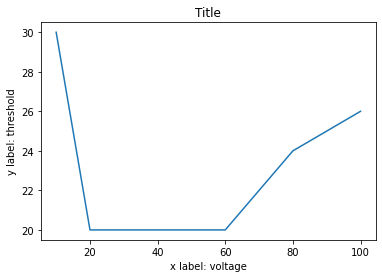

<ipython-input-268-e0c5fec626f9>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Simulation took 677.5 seconds


In [273]:
"""This main function defines what to run, what to simulate, what to process, what to plot..."""
def main():
 # Put your code here:
    
    #test_simulate_single_core()
    #test_simulate_multi_core(pool)
    
    # EXAMPLE:
    # test plot something:  best threshold vs expected voltage
     # parameters:
    real_expected_voltage_list = np.linspace(10, 100, num=10+1)
    threshold_list = np.linspace(20, 30, num=10+1)
    number_of_simulation_samples = 10
    expected_count = calculate_expected_count()
    bunch_crossing_count = 200
    
    x_list_voltage = []
    y_list_threshold = []
    
     # loop the expected voltages
    for real_expected_voltage in real_expected_voltage_list:
         # guess voltages +/- 5 from the real.
        guess_expected_voltage_list = np.linspace(real_expected_voltage-5, real_expected_voltage+5, num=10+1)
         # get the best threshold from the guess voltage list.
        threshold, deviation = compute_the_best_threshold_and_deviation_in_terms_of_least_average_deviation_sum(
                                    threshold_list,
                                    guess_expected_voltage_list,
                                    number_of_simulation_samples, 
                                    real_expected_voltage,
                                    expected_count,
                                    bunch_crossing_count
                                )
         # add data to the plot lists.
        x_list_voltage.append(real_expected_voltage)
        y_list_threshold.append(threshold)
        
     # plot the generated lists of data.
    plot_the_data("Title", "filename", "x label: voltage", "y label: threshold", x_list_voltage, y_list_threshold)

    
# === End of main() ===



# It is just a startup script, see main() above instead for the simulation code.
if __name__ == '__main__':
    mp.freeze_support()
    
    # profiles to determine compute resources
    profiles = {"normal": 2, "fast": 4, "fastest": 99}
    max_processes = profiles["fastest"]  # edit this
    
    # setup pool
    nprocs = min(mp.cpu_count(), max_processes)
    pool = None
    with mp.Pool(processes=nprocs) as poool:
        pool = poool
    
        global_counter = 0

        # run code
        t0 = time.time()
        main()
        t1 = time.time()
        print("Simulation took", round(t1-t0, 1), "seconds") # real time not the actuall process_time()

        # clean up
        pool.close()
        pool.join()


## Testing

In [255]:
def test():
    my_sim = simulation(threshold=30,
                        real_expected_voltage=100,
                        expected_count=30,
                        bunch_crossing_count=1000)  #500000
    my_sim.run()
    my_sim.run()
    
def test2():
    my_sim = simulation(threshold=15,
                        real_expected_voltage=30,
                        expected_count=60,
                        bunch_crossing_count=1000)
    my_sim.run()
    my_sim.run()


if __name__ == '__main__':
    import timeit
    print(timeit.timeit("test()", setup="from __main__ import test", number=1000))
    print(timeit.timeit("test2()", setup="from __main__ import test2", number=1000))
    

In [124]:
# Python version test
import platform
print(platform.python_version())
import sys
sys.implementation.name

3.8.2


'cpython'